In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


In [4]:
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("GPU DETECTED!")
else:
    print("No GPU found, using CPU")

TensorFlow version: 2.10.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU DETECTED!


### PATHS AND PARAMETERS

In [5]:
train_path  = 'Train'
test_path   = 'Test'
train_csv   = 'Train.csv'
test_csv    = 'Test.csv'
meta_csv    = 'Meta.csv'

IMG_HEIGHT  = 32
IMG_WIDTH   = 32
NUM_CLASSES = 43
BATCH_SIZE  = 64
EPOCHS      = 15

#### CLASS NAMES

In [6]:
class_names = {
    0:  'Speed limit 20km/h',
    1:  'Speed limit 30km/h',
    2:  'Speed limit 50km/h',
    3:  'Speed limit 60km/h',
    4:  'Speed limit 70km/h',
    5:  'Speed limit 80km/h',
    6:  'End speed limit 80km/h',
    7:  'Speed limit 100km/h',
    8:  'Speed limit 120km/h',
    9:  'No passing',
    10: 'No passing for vehicles >3.5t',
    11: 'Right of way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles >3.5t prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware ice/snow',
    31: 'Wild animals crossing',
    32: 'End all speed limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End no passing',
    42: 'End no passing >3.5t'
}

###  LOAD TRAINING DATA FROM FOLDERS

In [7]:
def load_images_from_folders(base_path, num_classes, img_height, img_width):
    images = []
    labels = []

    for class_id in range(num_classes):
        class_folder = os.path.join(base_path, str(class_id))

        if not os.path.exists(class_folder):
            continue

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)

            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((img_width, img_height))
                img = np.array(img)
                images.append(img)
                labels.append(class_id)
            except:
                continue

    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_folders(train_path, NUM_CLASSES, IMG_HEIGHT, IMG_WIDTH)
print(f"Training images loaded: {X_train.shape}")
print(f"Training labels: {y_train.shape}")

Training images loaded: (39209, 32, 32, 3)
Training labels: (39209,)


### LOAD TEST DATA FROM CSV

In [8]:
test_df = pd.read_csv(test_csv)
print(f"\nTest CSV columns: {test_df.columns.tolist()}")
print(test_df.head())

X_test = []
y_test = []

for _, row in test_df.iterrows():
    img_path = row['Path']

    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img = np.array(img)
        X_test.append(img)
        y_test.append(row['ClassId'])
    except:
        continue

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest images loaded: {X_test.shape}")
print(f"Test labels: {y_test.shape}")


Test CSV columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png

Test images loaded: (12630, 32, 32, 3)
Test labels: (12630,)


## PREPROCESSING

In [9]:
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

print(f"Pixel value range - Min: {X_train.min()}, Max: {X_train.max()}")

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat  = to_categorical(y_test,  NUM_CLASSES)

print(f"\nAfter one-hot encoding:")
print(f"y_train shape: {y_train_cat.shape}")
print(f"y_test shape:  {y_test_cat.shape}")

Pixel value range - Min: 0.0, Max: 1.0

After one-hot encoding:
y_train shape: (39209, 43)
y_test shape:  (12630, 43)


### EXPLORATORY DATA ANALYSIS


Total training samples: 39209
Total test samples:     12630
Number of classes:      43


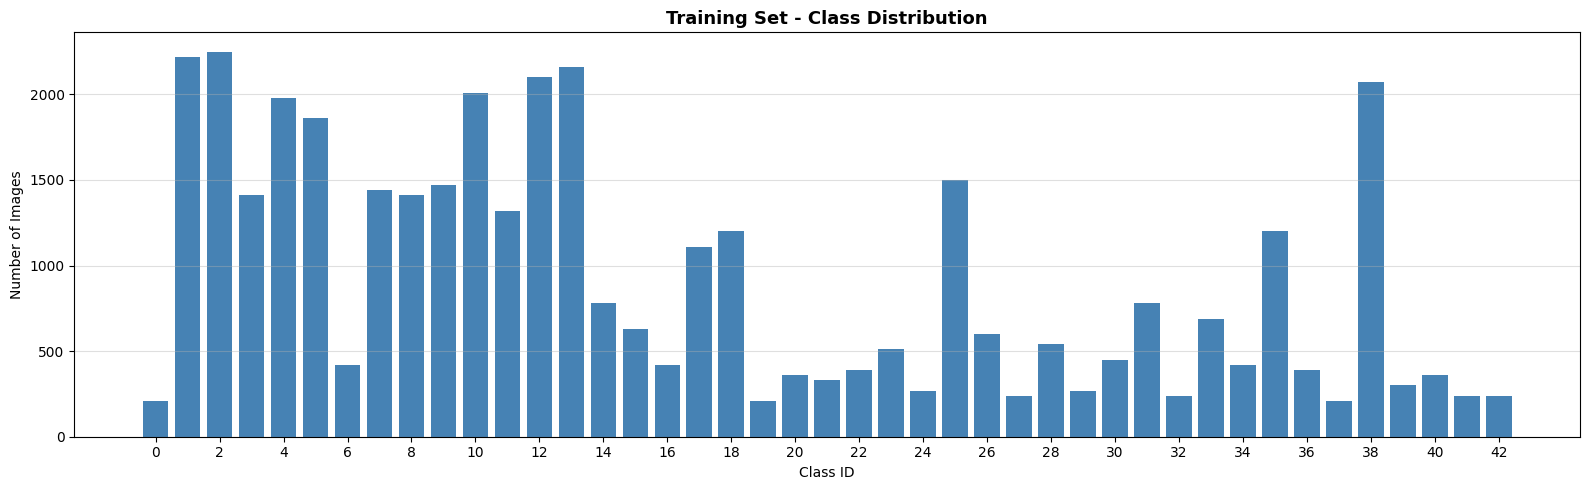

In [10]:
unique, counts = np.unique(y_train, return_counts=True)

print(f"\nTotal training samples: {len(X_train)}")
print(f"Total test samples:     {len(X_test)}")
print(f"Number of classes:      {NUM_CLASSES}")

# Class distribution bar chart
plt.figure(figsize=(16, 5))
plt.bar(unique, counts, color='steelblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Training Set - Class Distribution', fontweight='bold', fontsize=13)
plt.xticks(range(0, NUM_CLASSES, 2))
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

In [11]:
class_count_df = pd.DataFrame({'ClassId': unique, 'Count': counts})
class_count_df['ClassName'] = class_count_df['ClassId'].map(class_names)
class_count_df = class_count_df.sort_values('Count', ascending=False)

print("\nTop 5 most common classes:")
print(class_count_df.head(5).to_string(index=False))

print("\nTop 5 least common classes:")
print(class_count_df.tail(5).to_string(index=False))


Top 5 most common classes:
 ClassId  Count          ClassName
       2   2250 Speed limit 50km/h
       1   2220 Speed limit 30km/h
      13   2160              Yield
      12   2100      Priority road
      38   2070         Keep right

Top 5 least common classes:
 ClassId  Count            ClassName
      32    240 End all speed limits
      27    240          Pedestrians
      37    210  Go straight or left
      19    210 Dangerous curve left
       0    210   Speed limit 20km/h


### VISUALIZE SAMPLE IMAGES

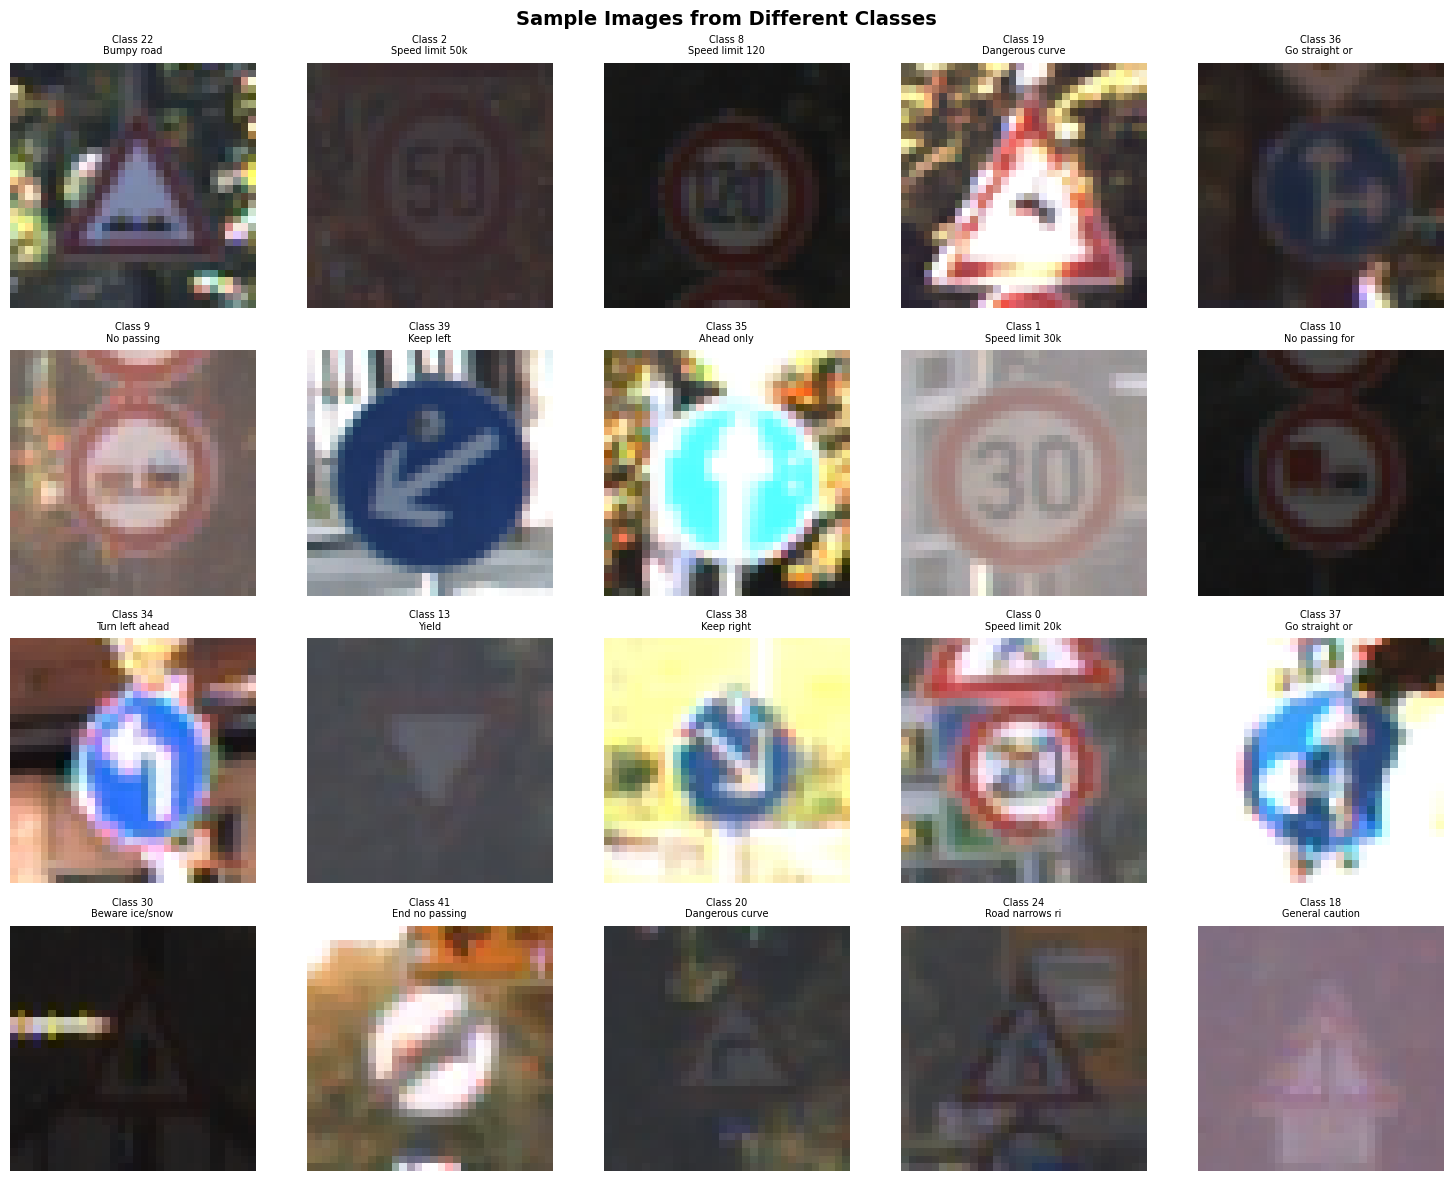

In [12]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

sample_classes = np.random.choice(range(NUM_CLASSES), 20, replace=False)

for i, class_id in enumerate(sample_classes):
    idx = np.where(y_train == class_id)[0][0]
    axes[i].imshow(X_train[idx])
    axes[i].set_title(f"Class {class_id}\n{class_names[class_id][:15]}", fontsize=7)
    axes[i].axis('off')

plt.suptitle('Sample Images from Different Classes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [13]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,    # traffic signs should NOT be flipped
    validation_split=0.2
)

datagen.fit(X_train)

train_generator = datagen.flow(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    subset='training'
)

val_generator = datagen.flow(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    subset='validation'
)

In [14]:
print(f"Training batches:   {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")

Training batches:   491
Validation batches: 123


### CNN MODEL

In [15]:
model = models.Sequential([

    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Classifier
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

### COMPILE MODEL

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel compiled!")


Model compiled!


### TRAIN MODEL

In [17]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

print("\nTraining complete!")

Epoch 1/15
491/491 [==============================] - 46s 73ms/step - loss: 2.1714 - accuracy: 0.3873 - val_loss: 14.2044 - val_accuracy: 0.0000e+00
Epoch 2/15
491/491 [==============================] - 35s 70ms/step - loss: 0.7075 - accuracy: 0.7618 - val_loss: 15.3302 - val_accuracy: 0.0588
Epoch 3/15
491/491 [==============================] - 34s 69ms/step - loss: 0.3176 - accuracy: 0.8946 - val_loss: 20.3185 - val_accuracy: 0.1393
Epoch 4/15
491/491 [==============================] - 34s 68ms/step - loss: 0.1842 - accuracy: 0.9424 - val_loss: 19.2558 - val_accuracy: 0.1831
Epoch 5/15
491/491 [==============================] - 33s 68ms/step - loss: 0.1405 - accuracy: 0.9568 - val_loss: 18.0449 - val_accuracy: 0.1868
Epoch 6/15
491/491 [==============================] - 33s 68ms/step - loss: 0.1198 - accuracy: 0.9636 - val_loss: 20.8211 - val_accuracy: 0.1668
Epoch 7/15
491/491 [==============================] - 34s 68ms/step - loss: 0.0964 - accuracy: 0.9720 - val_loss: 27.0999 - va

###  PLOT TRAINING HISTORY

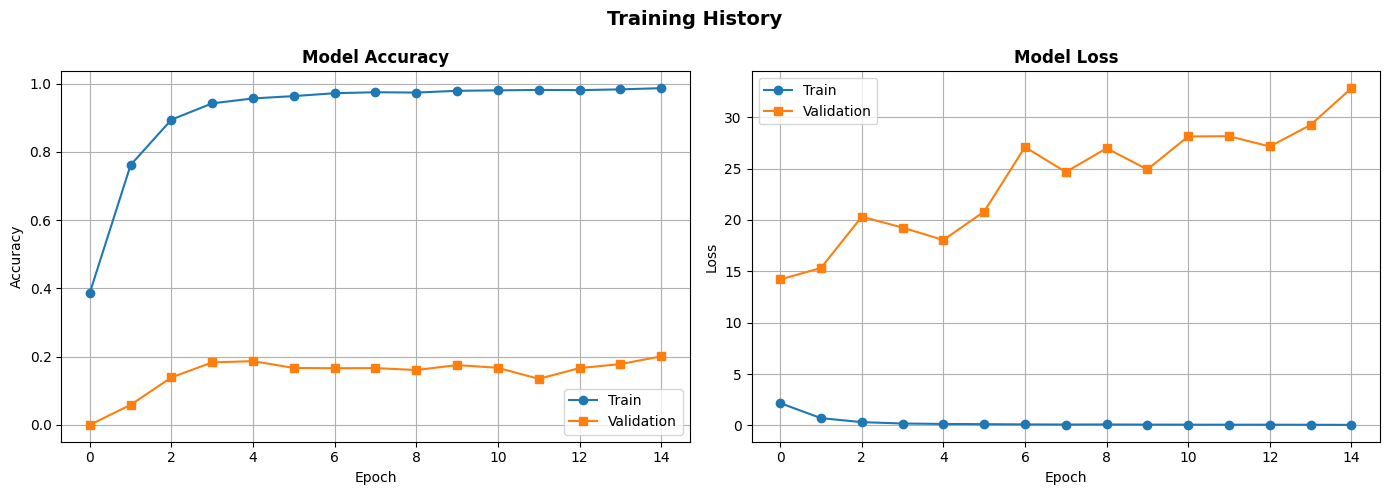

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation', marker='s')
axes[0].set_title('Model Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Loss
axes[1].plot(history.history['loss'], label='Train', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation', marker='s')
axes[1].set_title('Model Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### EVALUATE ON TEST SET

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)

print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

395/395 [==============================] - 3s 5ms/step - loss: 7.7200 - accuracy: 0.8215

Test Loss:     7.7200
Test Accuracy: 0.8215


### PREDICTIONS

In [21]:
y_pred_proba = model.predict(X_test, verbose=1)
y_pred       = np.argmax(y_pred_proba, axis=1)
print(f"Predictions generated: {len(y_pred)}")

395/395 [==============================] - 1s 3ms/step
Predictions generated: 12630


### CONFUSION MATRIX

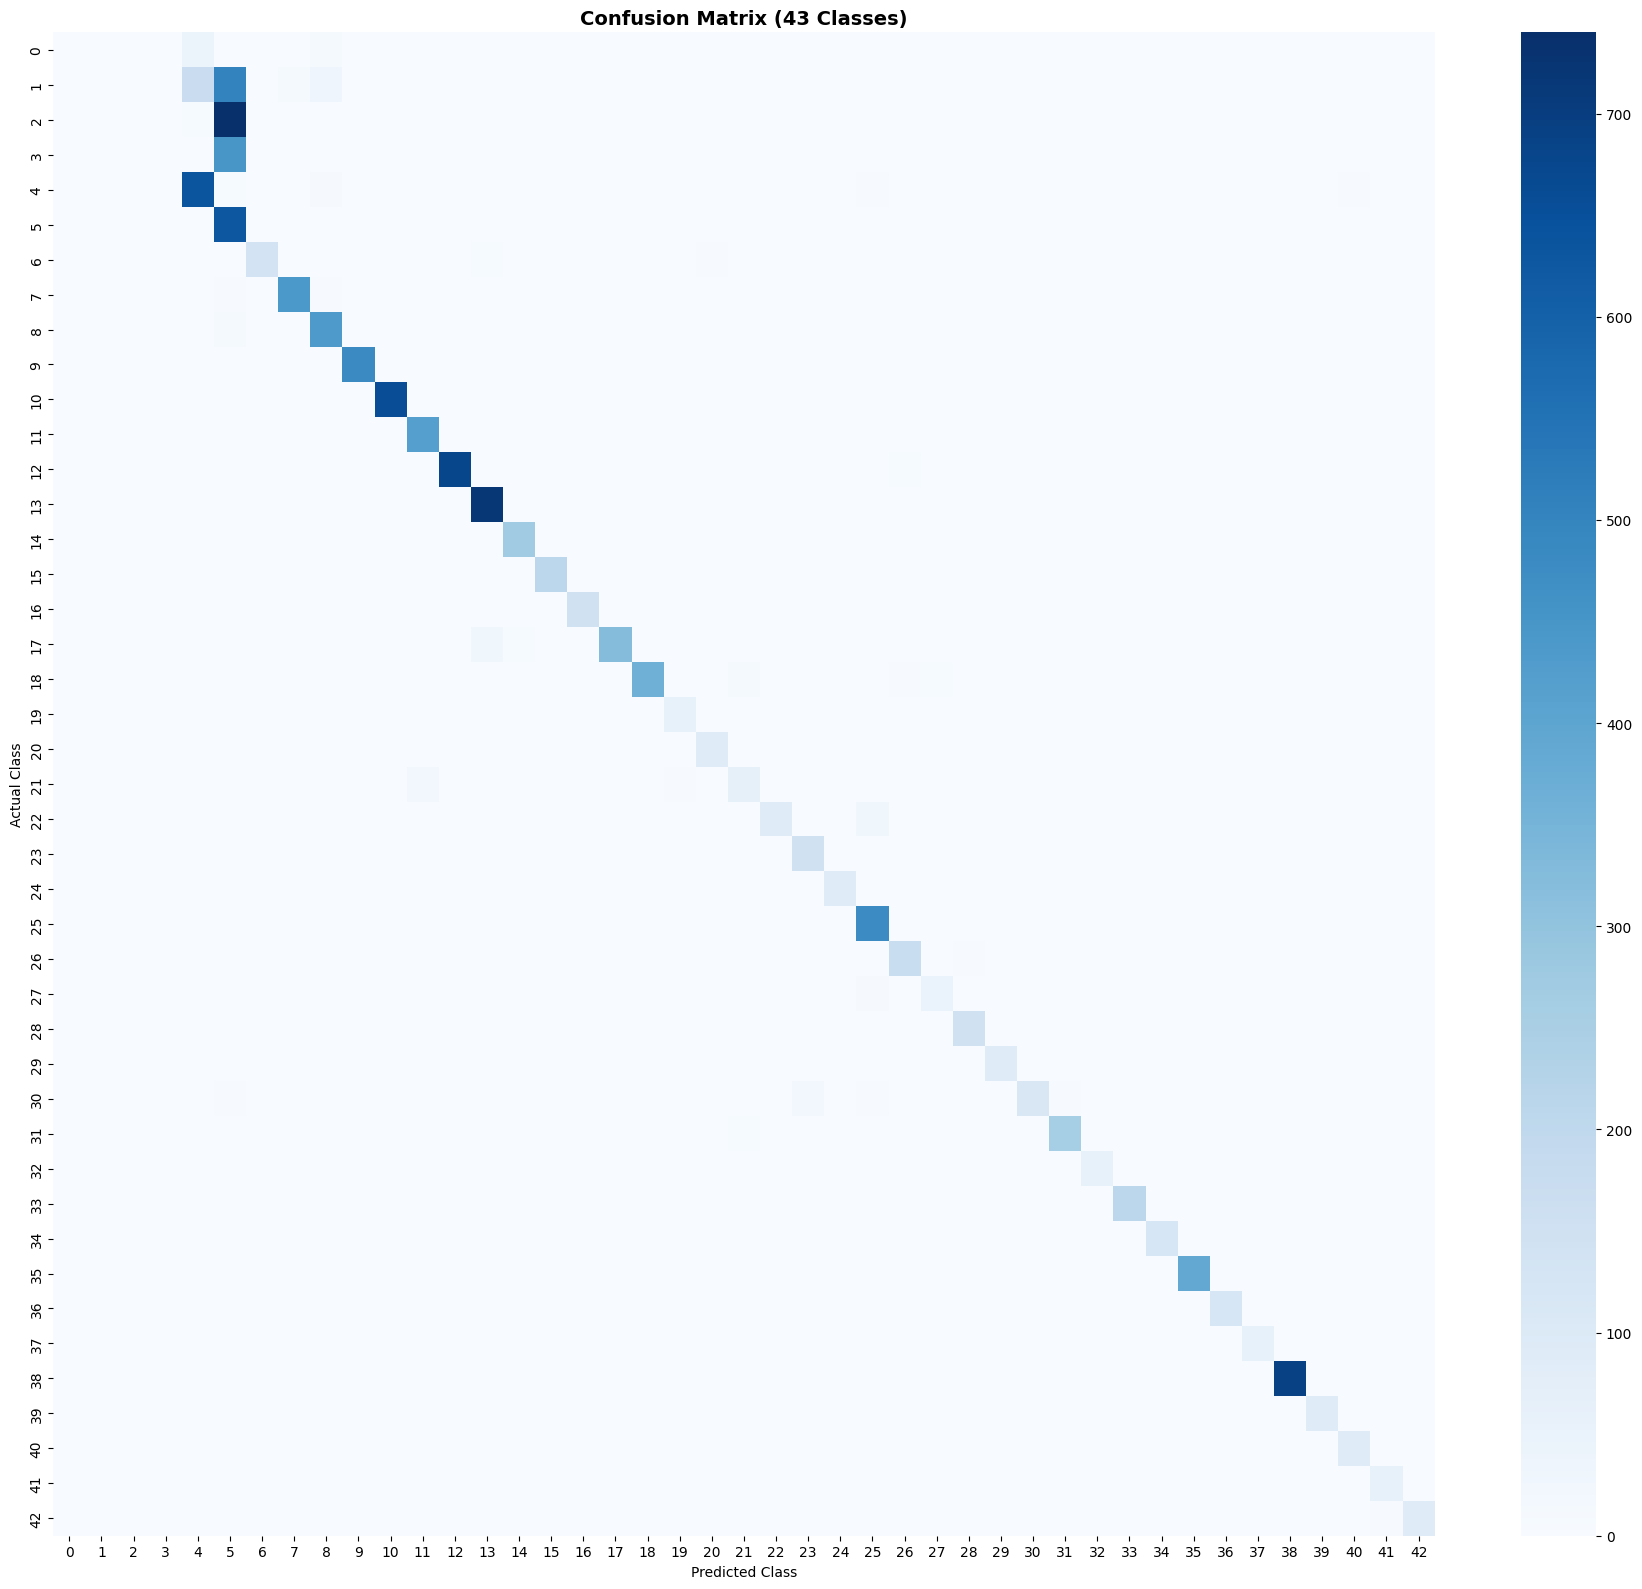

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=range(NUM_CLASSES),
            yticklabels=range(NUM_CLASSES))
plt.title('Confusion Matrix (43 Classes)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

### CLASSIFICATION REPORT

In [23]:
short_names = [class_names[i][:20] for i in range(NUM_CLASSES)]
print(classification_report(y_test, y_pred, target_names=short_names))

                      precision    recall  f1-score   support

  Speed limit 20km/h       0.00      0.00      0.00        60
  Speed limit 30km/h       0.00      0.00      0.00       720
  Speed limit 50km/h       0.00      0.00      0.00       750
  Speed limit 60km/h       0.00      0.00      0.00       450
  Speed limit 70km/h       0.74      0.96      0.83       660
  Speed limit 80km/h       0.27      1.00      0.42       630
End speed limit 80km       1.00      0.91      0.95       150
 Speed limit 100km/h       0.97      0.98      0.98       450
 Speed limit 120km/h       0.88      0.97      0.92       450
          No passing       1.00      1.00      1.00       480
No passing for vehic       1.00      1.00      1.00       660
Right of way at inte       0.95      1.00      0.97       420
       Priority road       1.00      0.98      0.99       690
               Yield       0.95      1.00      0.97       720
                Stop       0.97      1.00      0.99       270
       

### VISUALIZE MISCLASSIFICATIONS

Total misclassified: 2255 out of 12630
Misclassification rate: 17.85%


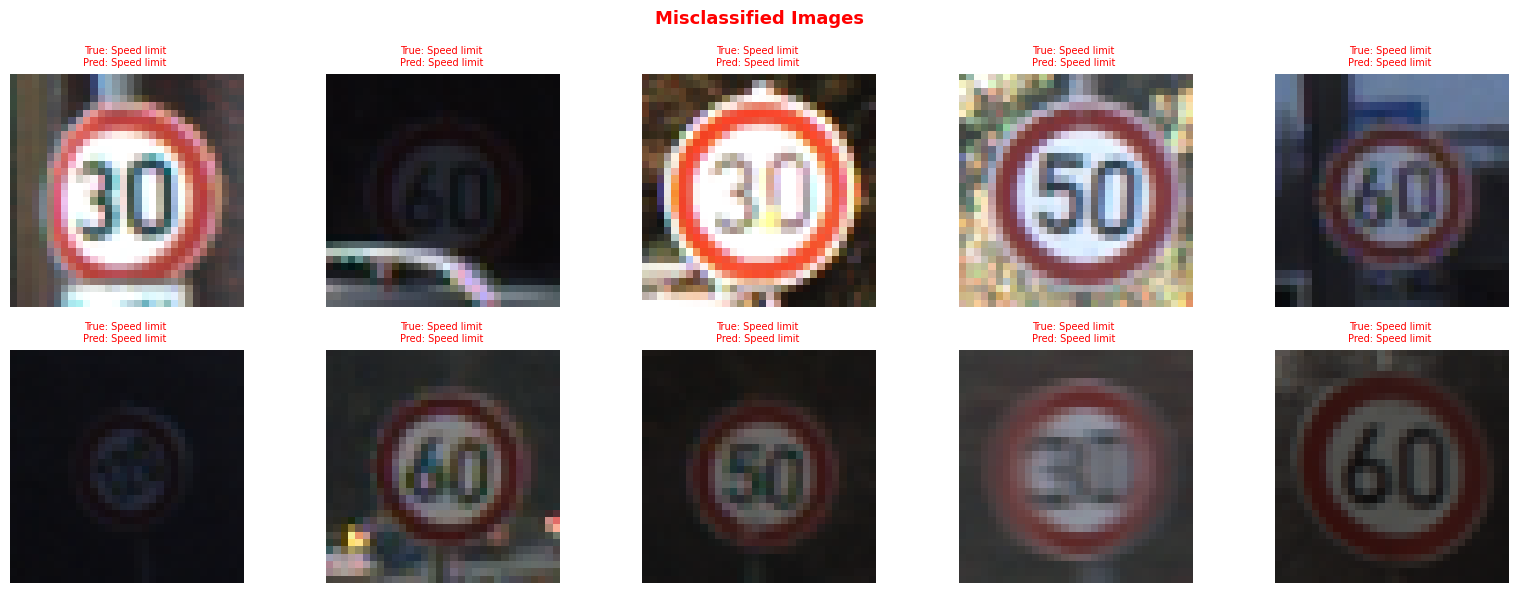

In [24]:

misclassified_idx = np.where(y_pred != y_test)[0]

print(f"Total misclassified: {len(misclassified_idx)} out of {len(y_test)}")
print(f"Misclassification rate: {len(misclassified_idx)/len(y_test)*100:.2f}%")

num_show = min(10, len(misclassified_idx))

plt.figure(figsize=(16, 6))
for i in range(num_show):
    idx = misclassified_idx[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    actual    = class_names[y_test[idx]][:12]
    predicted = class_names[y_pred[idx]][:12]
    plt.title(f'True: {actual}\nPred: {predicted}', color='red', fontsize=7)
    plt.axis('off')
plt.suptitle('Misclassified Images', fontsize=13, fontweight='bold', color='red')
plt.tight_layout()
plt.show()

### VISUALIZE CORRECT PREDICTIONS

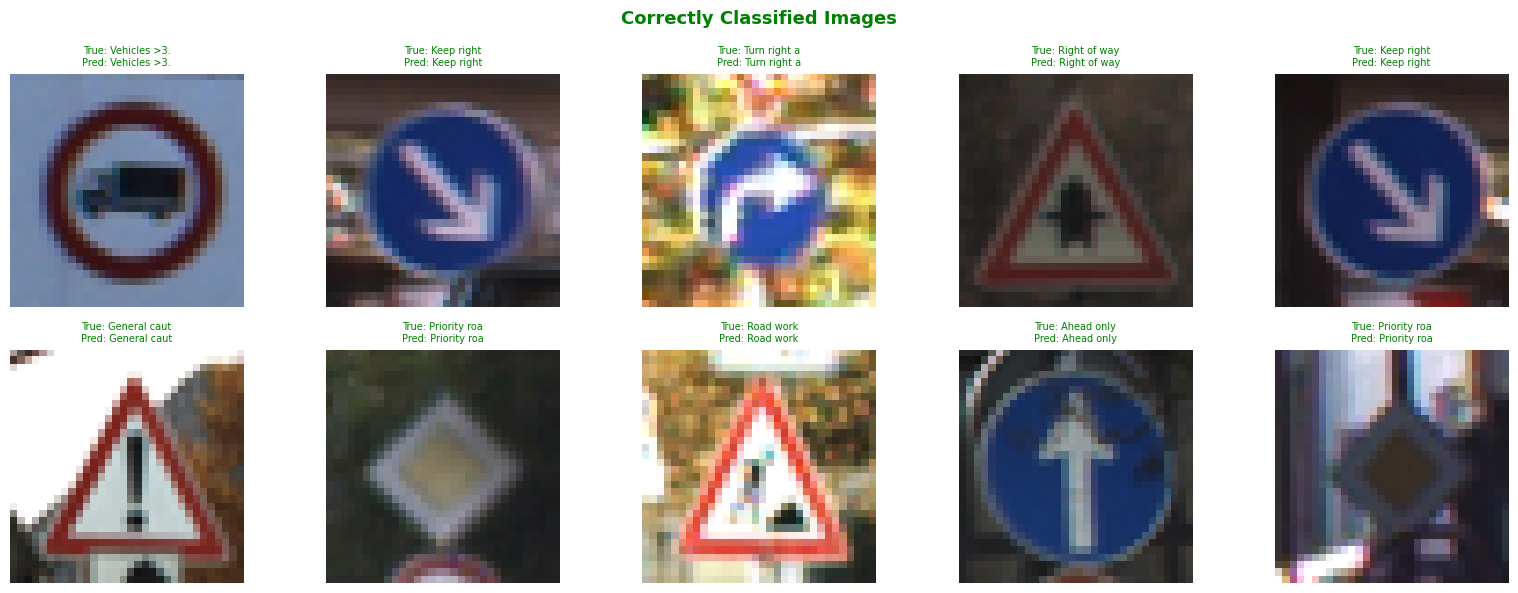

In [25]:
correct_idx  = np.where(y_pred == y_test)[0]
num_show_cor = min(10, len(correct_idx))

plt.figure(figsize=(16, 6))
for i in range(num_show_cor):
    idx = correct_idx[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    actual    = class_names[y_test[idx]][:12]
    predicted = class_names[y_pred[idx]][:12]
    plt.title(f'True: {actual}\nPred: {predicted}', color='green', fontsize=7)
    plt.axis('off')
plt.suptitle('Correctly Classified Images', fontsize=13, fontweight='bold', color='green')
plt.tight_layout()
plt.show()


### SUMMARY

In [27]:

print(f"\nDataset (GTSRB):")
print(f"  Training images: {len(X_train)}")
print(f"  Test images:     {len(X_test)}")
print(f"  Total classes:   {NUM_CLASSES}")

print(f"\nCNN Architecture:")
print(f"  Input size:      {IMG_HEIGHT}x{IMG_WIDTH}x3")
print(f"  Conv blocks:     3")
print(f"  Epochs trained:  {EPOCHS}")

print(f"\nResults:")
print(f"  Test Accuracy:   {test_accuracy:.4f}")
print(f"  Test Loss:       {test_loss:.4f}")
print(f"  Misclassified:   {len(misclassified_idx)} / {len(y_test)}")


Dataset (GTSRB):
  Training images: 39209
  Test images:     12630
  Total classes:   43

CNN Architecture:
  Input size:      32x32x3
  Conv blocks:     3
  Epochs trained:  15

Results:
  Test Accuracy:   0.8215
  Test Loss:       7.7200
  Misclassified:   2255 / 12630
